# About this notebook (1D GP)

This notebook aims to introduce the concept of Gaussian Process (GP) to students in an incremental fashion. New functionalities are added in a step-wise fashion to build upon previously learnt concepts.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as pl
from scipy.optimize import fmin_l_bfgs_b as bfgs
from scipy.optimize import minimize 

## Task 1: Generating 1D data for inference

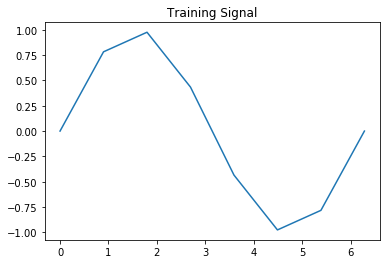

In [2]:
# Number of data samples
numObs = 8 # Number of Observations
numTest = 100 # Number of testing inputs

# Jitter Quantities
eps = 1.49e-08 ## really small jitter for numerical stability


# Noiseless training data
Xtrain = np.linspace(start=0, stop=2*math.pi, num=numObs)[:, np.newaxis] # Training Inputs
ytrain = np.sin(Xtrain) # Training Targets

fig, ax = pl.subplots()
pl.plot(Xtrain, ytrain)
pl.title('Training Signal')
pl.show()

# Test data
Xtest = np.linspace(start=-0.5, stop=2*math.pi+0.5, num=numTest)[:, np.newaxis]

## Task 2: Implement the Squared Eucledian Distance Function.

In [3]:
# Define the kernel function
def Sq_Euclid_DistMat(X1,X2):
    '''
    L2-norm applicable for both vectors and matrices (useful for high dimension input features.)
    Parameter Description:
    X1,X2: When X1==X2, then calculate autocorrelation. Otherwise cross-correlations.
    DistMat: Pairwise Squared Distance Matrix of size nXn
    '''
    if X1.shape[1] == 1:  # vectors
        n = X1.shape[0]
        m = X2.shape[0]
        r1 = X1.reshape(n, 1) * np.ones([1, m])
        r2 = X2.reshape(1, m) * np.ones([n, 1])
        sed = ((r1 - r2) ** 2)
    elif X1.shape[1] == 2:  # matrices for 2D feature space.
        n = X1.shape[0]
        m = X2.shape[0]
        r1x = X1[:, 0].reshape(n, 1) * np.ones([1, m])
        r1y = X1[:, 1].reshape(n, 1) * np.ones([1, m])
        r2x = X2[:, 0].reshape(1, m) * np.ones([n, 1])
        r2y = X2[:, 1].reshape(1, m) * np.ones([n, 1])
        sed = ((r1x - r2x) ** 2 + (r1y - r2y) ** 2)
    else:
        print ("too many dimensions in X matrices", X1.shape)
        return None

    return sed

## Task 3: Now make draws from a multivariate Gaussian pdf with Mean as 0 and covariance given by the RBF Kernel from above. Start off with 1 draw and then draw 5 priors.

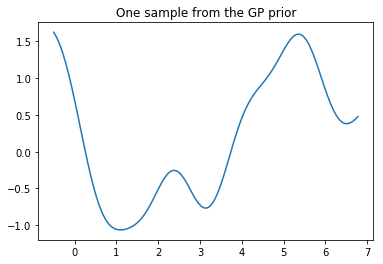

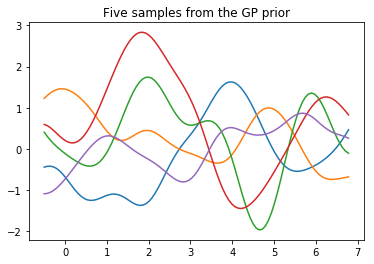

In [4]:
np.random.seed(1) # set seed for consistency

DXtest = Sq_Euclid_DistMat(Xtest,Xtest)
K_ss = np.exp(-DXtest) # Auto-correlation between test points K(X*,X*)

# Get the lower cholesky factor of the covariance matrix
L = np.linalg.cholesky(K_ss+eps*np.eye(numTest))

## Make 1 draw
f_prior1 = np.dot(L, np.random.normal(size=(numTest,1)))

# Plotting the drawn prior.
fig, ax = pl.subplots()
pl.plot(Xtest, f_prior1)
pl.title('One sample from the GP prior')
pl.show()

## Now make 5 draws
f_prior5 = np.dot(L, np.random.normal(size=(numTest,5)))

# Plotting all 5 priors.
fig, ax = pl.subplots()
pl.plot(Xtest, f_prior5)
pl.title('Five samples from the GP prior')
pl.show()


## Task 4: Now, let us make a posterior for 100 samples that were not used previously for training the GP.

Note that the posterior mean and covariance look as follows:

\begin{align}
\begin{split}
\mu_{f|D} &\triangleq \underbrace{\mathcal{K^*}^T\mathcal{K}^{-1}(\mathbf{f} -\mu)}_\text{Corrector}  \,,\\
\mathcal{K}_{f|D} &\triangleq \underbrace{\underbrace{\mathcal{K^{**}}}_\text{Prior} - \underbrace{\mathcal{K^*}^T\mathcal{K}^{-1}\mathcal{K^*}}_\text{Evidence}}_\text{Reduction in Variance} 
\end{split}
\end{align}

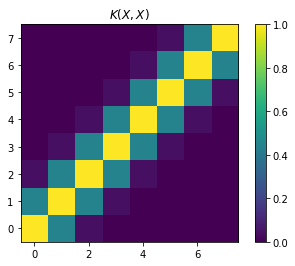

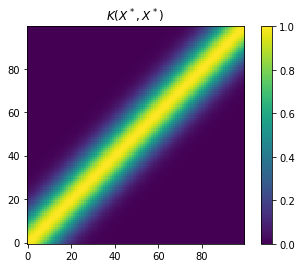

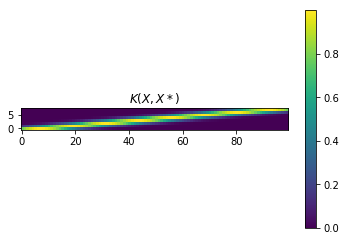

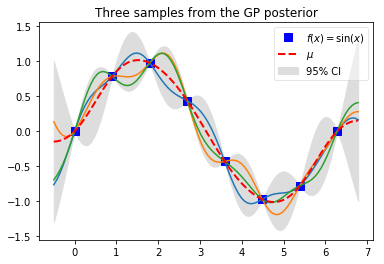

In [5]:
# Generate all necessary kernels for predictions
D = Sq_Euclid_DistMat(Xtrain,Xtrain) # Squared Eucledian Distance
K = np.exp(-D + np.diag(eps*np.ones(numObs))) # K(X,X)
fig, ax = pl.subplots()
pl.imshow(K)
ax.set_ylim(ax.get_ylim()[::-1]) 
pl.colorbar()
pl.title(u'$K(X,X)$')


fig, ax = pl.subplots()
pl.imshow(K_ss)
ax.set_ylim(ax.get_ylim()[::-1])
pl.colorbar()
pl.title(u'$K(X^*,X^*)$')


# Apply the kernel function to our training points
L = np.linalg.cholesky(K) # lower cholesky factor 

# Compute the mean at our test points.
DX = Sq_Euclid_DistMat(Xtrain, Xtest)
K_s = np.exp(-DX) # Cross Correlation between test and train inputs
fig, ax = pl.subplots()
pl.imshow(K_s)
ax.set_ylim(ax.get_ylim()[::-1]) 
pl.colorbar()
pl.title(u'$K(X,X*)$')

Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((numTest,))

# Compute the standard deviation to find the upper and lower Quantiles
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0) # variance
stdv = np.sqrt(s2) # std deviation

# Draw samples from the posterior at the test points.
L = np.linalg.cholesky(K_ss+eps*np.eye(numTest) - np.dot(Lk.T, Lk)) # add small jitter to keep the kernel psd
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(numTest,3)))

# Generate Plots
fig, ax = pl.subplots()
pl.plot(Xtrain, ytrain, 'bs', ms=8,label=u'$f(x) = \sin(x)$') # Original Data
pl.plot(Xtest, f_post) # Posterior Samples
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd",label='95% CI') # 95% CI
pl.plot(Xtest, mu, 'r--', lw=2,label=u'$\mu$') # Posterior Mean
ax.legend(loc='best', fancybox=True, framealpha=0.5)
pl.title('Three samples from the GP posterior')
pl.show()


## Impact of Scaled Data

#### Here, we want to analyse the impact of scaling the data. Imagine, that instead of $f(x) = \sin(x)$ we now want to model $f(x) = 5\sin(x)$. This would just scale all the values by a factor of $5$ and the GP fit should still be applicable. However, something interesting happens in this case. Try it out to see for yourself.

## Task 5: Incorporate the data scale while fitting the GPs. This entails scaling the covariance. When done appropriately, the GP fit will perform just like before and will not underestimate the variance.

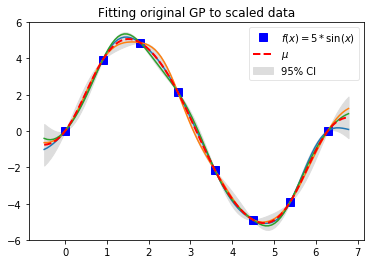

In [6]:
yScaled = 5*np.sin(Xtrain)  # Scaled Targets

# Apply the kernel function to our training points
D = Sq_Euclid_DistMat(Xtrain,Xtrain) # Squared Eucledian Distance
K = np.exp(-D + np.diag(eps*np.ones(numObs))) # K(X,X)
L = np.linalg.cholesky(K) # lower cholesky factor


muScaled = np.dot(Lk.T, np.linalg.solve(L, yScaled)).reshape((numTest,))

# Compute the standard deviation to find the upper and lower Quantiles
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at the test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(numTest) - np.dot(Lk.T, Lk))
f_post = muScaled.reshape(-1,1) + np.dot(L, np.random.normal(size=(numTest,3)))

# Generate Plots
fig, ax = pl.subplots()
pl.plot(Xtrain, yScaled, 'bs', ms=8,label=u'$f(x) = 5*\sin(x)$') # Original Data
pl.plot(Xtest, f_post) # Posterior Samples
pl.gca().fill_between(Xtest.flat, muScaled-2*stdv, muScaled+2*stdv, color="#dddddd",label='95% CI') # 95% CI
pl.plot(Xtest, muScaled, 'r--', lw=2,label=u'$\mu$') # Posterior Mean
ax.legend(loc='best', fancybox=True, framealpha=0.5)
pl.title('Fitting original GP to scaled data')
pl.show()


## Noisy Data

## Task 6: What if the data was noisy? Usually, in real world, most observations are noisy. Try adding a white noise with known variance to the data and then fitting the original GP to the noisy data.

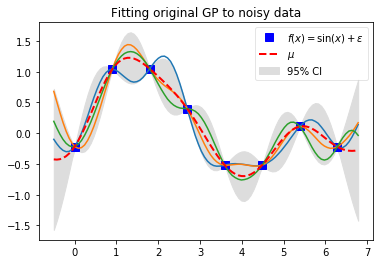

In [7]:
# Generate noisy targets
noise_scale = 0.4
noise_mean = 0 # zero mean gaussian noise
noise_var = 1 # true variance of noise being added
noise = noise_scale * np.random.normal(noise_mean,noise_var,numObs)[:, np.newaxis]
Y_noisy = ytrain + noise # Noisy targets

# Fitting the original GP here.
D = Sq_Euclid_DistMat(Xtrain,Xtrain) # Squared Eucledian Distance
K = np.exp(-D + np.diag(eps*np.ones(numObs))) # K(X,X)
L = np.linalg.cholesky(K) # lower cholesky factor

muNoisy = np.dot(Lk.T, np.linalg.solve(L, Y_noisy)).reshape((numTest,))

# Compute the standard deviation to find the upper and lower Quantiles
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at the test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(numTest) - np.dot(Lk.T, Lk))
f_post = muNoisy.reshape(-1,1) + np.dot(L, np.random.normal(size=(numTest,3)))

# Generate Plots
fig, ax = pl.subplots()
pl.plot(Xtrain, Y_noisy, 'bs', ms=8,label=u'$f(x) = \sin(x) + \epsilon$') # Original Data
pl.plot(Xtest, f_post) # Posterior Samples
pl.gca().fill_between(Xtest.flat, muNoisy-2*stdv, muNoisy+2*stdv, color="#dddddd",label='95% CI') # 95% CI
pl.plot(Xtest, muNoisy, 'r--', lw=2,label=u'$\mu$') # Posterior Mean
ax.legend(loc='best', fancybox=True, framealpha=0.5)
pl.title('Fitting original GP to noisy data')
pl.show()


## Likelihood

We started off with a 1-D prior and directly landed up with a posterior. However, as per Bayes rule, for carrying out Bayesian inference we have $Posterior\propto likelihood \times prior$. So, what happened to the likelihood? Likelihood, by definition, explains how likely it is to see the data points given the model that generated the data. Thus, we know that $Y\sim \mathcal{N}(0,\sigma_{sig}^2K(\cdot,\cdot))$. The likelihood of this data generating MVN-pdf is then given by, $\mathcal{L} = (2\pi\sigma_{sig}^2)^{\dfrac{-n}{2}} |K|^{\dfrac{-1}{2}}\exp{-\dfrac{1}{2\sigma_{sig}^2}Y^TK^{-1}Y}$. Taking the log of this, we get $\mathcal{l} = -\dfrac{n}{2}\log(2\pi)-\dfrac{n}{2}\log(\sigma_{sig}^2)-\dfrac{1}{2}\log|K|-\dfrac{1}{2\sigma_{sig}^2}Y^TK^{-1}Y$.

## Maximum Likelihood Estimation
Now that we know the log likelihood equation from above, all that remains is to find the gradient of this function with respect to each of the hyper-parameters introduced earlier. Thus, we need gradient with respect to $\sigma_{sig}$ which can be obtained as follows:
\begin{align}
\begin{split}
0\stackrel{set}{=}\mathcal{l}'&=-\dfrac{n}{2\sigma_{sig}^2}+\dfrac{1}{2\sigma_{sig}^2}Y^TK^{-1}Y\\
\Rightarrow \sigma_{sig}^2 &=\dfrac{Y^TK^{-1}Y}{n} 
\end{split}
\end{align}
 where $n = #(Y)$ represents the cardinality i.e., the number of observations.

### Task 7: Perform MLE for $\sigma_{sig}^2$ i.e., $\hat{\sigma}^2_{sig}$

In [8]:
c = np.linalg.inv(np.linalg.cholesky(K))
Ci = np.dot(c.T,c) 

C_ss=K_ss

sigma_sigSq = np.dot(np.dot((yScaled).T,Ci),yScaled) / numObs
EstDataScale = 2*np.sqrt(sigma_sigSq)
print("Data Scale Estimated as: ",EstDataScale[0][0])

('Data Scale Estimated as: ', 5.486647883275056)


which is close to what we know as the truth. Remember that we scaled the target values by a factor of $5$. Now, estimate the predictive mean and covariance for the scaled data to adapt the GP to the scale of the data. Note that the revised posterior equations now look as follows:
\begin{align}
\begin{split}
\mu_{f|D} &\triangleq \underbrace{\mathcal{K^*}^T\mathcal{K}^{-1}(\mathbf{f} -\mu)}_\text{Corrector}  \,,\\
\mathcal{K}_{f|D} &\triangleq \sigma^2_{sig}[\underbrace{\underbrace{\mathcal{K^{**}}}_\text{Prior} - \underbrace{\mathcal{K^*}^T\mathcal{K}^{-1}\mathcal{K^*}}_\text{Evidence}}_\text{Scaled reduction in Var}]
\end{split}
\end{align}

Notice here that the signal variance i.e., $\sigma^{2}_{sig}$ does not factor into the predictive mean but only the covariance.

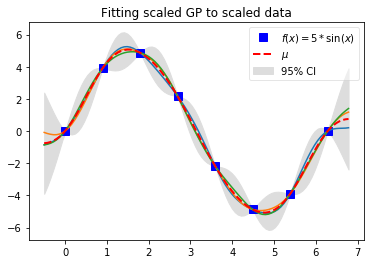

In [9]:
# Apply the kernel function to our training points
D = Sq_Euclid_DistMat(Xtrain,Xtrain) # Squared Eucledian Distance
K = np.exp(-D + np.diag(eps*np.ones(numObs))) # K(X,X)
L = np.linalg.cholesky(K) # lower cholesky factor


muScaled = np.dot(Lk.T, np.linalg.solve(L, yScaled)).reshape((numTest,))

# Compute the standard deviation to find the upper and lower Quantiles
s2 = sigma_sigSq[0]*(np.diag(K_ss) - np.sum(Lk**2, axis=0))
stdv = np.sqrt(s2)

# Draw samples from the posterior at the test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(numTest) - np.dot(Lk.T, Lk))
f_post = muScaled.reshape(-1,1) + np.dot(L, np.random.normal(size=(numTest,3)))

# Generate Plots
fig, ax = pl.subplots()
pl.plot(Xtrain, yScaled, 'bs', ms=8,label=u'$f(x) = 5*\sin(x)$') # Original Data
pl.plot(Xtest, f_post) # Posterior Samples
pl.gca().fill_between(Xtest.flat, muScaled-2*stdv, muScaled+2*stdv, color="#dddddd",label='95% CI') # 95% CI
pl.plot(Xtest, muScaled, 'r--', lw=2,label=u'$\mu$') # Posterior Mean
ax.legend(loc='best', fancybox=True, framealpha=0.5)
pl.title('Fitting scaled GP to scaled data')
pl.show()


### Task 8: Perform MLE for $\sigma_{noise}^2$ i.e., $\hat{\sigma}_{noise}$

In [10]:
def nll_n(sig_n,DistMat,Y):
    '''
    Function to obtain the negative log likelihood for the noise HP
    sig_n: noise std. dev
    DistMat: Pairwise Eucledian Distance Matrix
    Y: List of targets/ Observations
    
    :return: negative log likelihood -ll
    '''
    K = np.exp(-DistMat) + np.diag(sig_n**2*np.ones(numObs))
    c = np.linalg.inv(np.linalg.cholesky(K))
    Ki = np.dot(c.T,c) 
    (sign, logdetK) = np.linalg.slogdet(K)
    ll = -numObs/2 * np.log(np.dot(Y.T,(np.dot(Ki,Y)))) - 1/2 * logdetK
    return -ll

def gnll_n(sig_n,DistMat,Y):
    '''
    Function to obtain gradient of negative log-likelihood for the noise HP
    sig_n: noise std. dev
    DistMat: Pairwise Eucledian Distance Matrix
    Y: List of targets/ Observations
    
    :return: negative gradients of negative log likelihood -dll
    '''
    K = np.exp(-DistMat) + np.diag(sig_n**2*np.ones(numObs))
    c = np.linalg.inv(np.linalg.cholesky(K))
    Ki = np.dot(c.T,c)
    KiY = np.dot(Ki,Y)
    dll = (numObs)/2 * np.dot(KiY.T,KiY)/(np.dot(Y.T,KiY)) - 1/2*(np.sum(np.diag(Ki)))
    return -dll
   
YScaled_noisy = yScaled + noise # Noisy scaled targets
noise_bounds = [(eps, np.var(YScaled_noisy))]   # lower and upper-bounds for noise variance 
initial_guess = 0.1*np.var(YScaled_noisy)
DistMat = Sq_Euclid_DistMat(Xtrain,Xtrain)
res = minimize(nll_n, initial_guess,args=(DistMat,YScaled_noisy), method="L-BFGS-B",\
               jac=gnll_n, bounds = noise_bounds,options={'maxiter':1000, 'gtol': 1e-6, 'disp': True})

sig_n = np.sqrt(res.x[0]) # Noise std. dev
print("Optimal Noise Hyper-parameter: ",sig_n) # best theta
print("Optimal Negative Log-Likelihood: ",res.fun[0][0]) # log marginal likelihood.
print("Convergence Status: ",res.message) 
print("No. of Evaluations: ", res.nfev)

# Plug back to find tau_hat*2
K = np.exp(-DistMat) + np.diag(sig_n**2*np.ones(numObs))
c = np.linalg.inv(np.linalg.cholesky(K))
Ki = np.dot(c.T,c)
sigma_sigSq = np.dot(np.dot((YScaled_noisy).T,Ci),YScaled_noisy) / numObs
EstDataScale = 2*np.sqrt(sigma_sigSq)
print("Data Scale Estimated as: ",EstDataScale[0][0])

('Optimal Noise Hyper-parameter: ', 3.162882354951778)
('Optimal Negative Log-Likelihood: ', -0.947433129576186)
('Convergence Status: ', 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL')
('No. of Evaluations: ', 7)
('Data Scale Estimated as: ', 5.269091591869745)


### Task 9: Finally perform MLE  for both  $l$ i.e., $\hat{l}$ and $\hat{\sigma}_{noise}$. 

In [11]:
def nll(params,DistMat,Y):
    '''
    Function to obtain the negative log likelihood for the length scale and noise
    params: length scale and noise std_dev as a list
    DistMat: Pairwise Eucledian Distance Matrix
    Y: List of targets/ Observations
    
    :return: negative log likelihood -ll
    '''
    length_scale = params[0] ## Account for length scale here
    sig_n = params[1] ## Noise std. deviation
    K = np.exp(-DistMat/length_scale) + np.diag(sig_n**2*np.ones(numObs)) ## Note the change here
    c = np.linalg.inv(np.linalg.cholesky(K+eps*(np.eye(numObs))))
    Ki = np.dot(c.T,c) 
    (sign, logdetK) = np.linalg.slogdet(K)
    ll = -numObs/2 * np.log(np.dot(Y.T,(np.dot(Ki,Y)))) - 1/2 * logdetK
    return -ll

def gnll(params,DistMat,Y):
    '''
    Function to obtain gradient of negative log-likelihood
    sig_n: noise std. dev
    DistMat: Pairwise Eucledian Distance Matrix
    Y: List of targets/ Observations
    
    :return: negative gradients of negative log likelihood -dll
    '''
    length_scale = params[0] ## Account for length scale here
    sig_n = params[1]
    K = np.exp(-DistMat/length_scale) + np.diag(sig_n**2*np.ones(numObs)) ## Note the change here
    c = np.linalg.inv(np.linalg.cholesky(K+eps*(np.eye(numObs))))
    Ki = np.dot(c.T,c)
    KiY = np.dot(Ki,Y)
    dotK = np.dot(K,DistMat)/(length_scale**2)
    
    # Compute derivatives for both components separately
    dll_ls = (numObs)/2 * np.dot(KiY.T,np.dot(dotK,KiY))/(np.dot(Y.T,KiY))\
            - (1/2)*(np.sum(np.diag(np.dot(Ki,dotK)))) # for length scale
    dll_n = (numObs)/2 * np.dot(KiY.T,KiY)/(np.dot(Y.T,KiY)) - 1/2*(np.sum(np.diag(Ki))) # for noise
    return(np.concatenate((dll_ls, dll_n), axis=0))
    

initial_guess = [(0.1,0.1*np.var(YScaled_noisy))]
HP_bounds = ((eps, 10),(eps, np.var(YScaled_noisy)))


DistMat = Sq_Euclid_DistMat(Xtrain,Xtrain)
res = minimize(nll, initial_guess,args=(DistMat,YScaled_noisy), method="L-BFGS-B",\
               jac=gnll,bounds = HP_bounds,options={'maxiter':1000, 'gtol': 1e-6, 'disp': True})

print("Optimal length scale: ",res.x[0]) 
print("Optimal Noise Variance: ",res.x[1])
print("Optimal Negative Log-Likelihood: ",res.fun[0][0]) # log marginal likelihood.
print("Convergence Status: ",res.message) 
print("No. of Evaluations: ", res.nfev)

('Optimal length scale: ', 0.1)
('Optimal Noise Variance: ', 1.0003824791265303)
('Optimal Negative Log-Likelihood: ', 14.762654156662636)
('Convergence Status: ', 'ABNORMAL_TERMINATION_IN_LNSRCH')
('No. of Evaluations: ', 21)
